# Telemetry-to-Insight: Full Pipeline Demo

End-to-end: load telemetry with cuDF, retrieve filtered data, send to NIM for natural-language answers.

**Colab:** You need NIM running on GKE with a public URL. Paste your NIM URL in the Setup cell below. See "Deploy NIM on GKE" at the end of this notebook.

<a href="https://colab.research.google.com/github/KarthikSriramGit/H.E.I.M.D.A.L.L/blob/main/notebooks/03_query_telemetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Configure runtime first:** Runtime > Change runtime type > Hardware accelerator: **GPU** or **None** > Save.

In [1]:
# Colab setup: clone repo and install dependencies (run this cell first)
try:
    import google.colab
    get_ipython().system("git clone -q https://github.com/KarthikSriramGit/H.E.I.M.D.A.L.L.git")
    get_ipython().run_line_magic("cd", "H.E.I.M.D.A.L.L")
    get_ipython().system("pip install -q -r requirements.txt")
except Exception:
    pass

/content/H.E.I.M.D.A.L.L


## Setup

**Store your NIM IP securely using Colab Secrets (recommended):**
1. In Colab, click the **key icon** (Secrets) in the left sidebar.
2. Add a new secret: Name = `NIM_BASE_URL`, Value = `http://YOUR_EXTERNAL_IP:8000`
3. Toggle **Notebook access** to ON.

The cell below reads from Colab Secrets automatically. If no secret is set, it falls back to the `NIM_BASE_URL` environment variable or a placeholder.

In [2]:
import os
import sys
import subprocess
from pathlib import Path

ROOT = Path(".").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Read NIM URL from Colab Secrets (preferred) or environment variable
try:
    from google.colab import userdata
    NIM_BASE_URL = userdata.get("NIM_BASE_URL")
except (ImportError, userdata.SecretNotFoundError):
    NIM_BASE_URL = os.environ.get("NIM_BASE_URL", "http://YOUR_EXTERNAL_IP:8000")

if "YOUR_EXTERNAL_IP" in NIM_BASE_URL:
    print("WARNING: Set NIM_BASE_URL in Colab Secrets (key icon in sidebar) or as an environment variable.")
    print("         Value should be: http://<YOUR_LOADBALANCER_IP>:8000")

data_path = ROOT / "data" / "synthetic" / "fleet_telemetry.parquet"
if not data_path.exists():
    subprocess.run([
        "python", "data/synthetic/generate_telemetry.py",
        "--rows", "100000", "--output-dir", "data/synthetic", "--format", "parquet",
    ], check=True, cwd=str(ROOT))

from src.query.engine import TelemetryQueryEngine

engine = TelemetryQueryEngine(
    data_path=str(data_path),
    nim_base_url=NIM_BASE_URL,
    max_context_rows=500,
)
print(f"Engine ready. NIM URL: {NIM_BASE_URL.split('/')[0]}//<HIDDEN>:{NIM_BASE_URL.split(':')[-1]}")

Engine ready. NIM URL: http://<HIDDEN>:8000


## Batch run (comparison with notebook 02)

Runs the same queries as notebook 02 through NIM (Llama 3 8B on GKE). Results and plots below let you compare local vs cloud inference.

In [3]:
import time
import matplotlib.pyplot as plt
from src.query.query_config import QUERY_CONFIG
from src.query.prompts import format_user_query, SYSTEM_PROMPT
from src.deploy.nim_client import NIMClient

results_03 = []
nim_client = NIMClient(base_url=NIM_BASE_URL, max_tokens=256)

for cfg in QUERY_CONFIG:
    if cfg.get("skip_data"):
        user_msg = format_user_query(cfg["query"], "No telemetry data: general knowledge question about ML deployment.")
        t0 = time.perf_counter()
        answer = nim_client.ask(user_msg, system_context=SYSTEM_PROMPT)
        latency_s = time.perf_counter() - t0
    else:
        t0 = time.perf_counter()
        answer = engine.query(
            cfg["query"],
            vehicle_ids=cfg.get("vehicle_ids"),
            sensor_type=cfg.get("sensor_type"),
            brake_threshold=cfg.get("brake_threshold"),
        )
        latency_s = time.perf_counter() - t0
    results_03.append({
        "id": cfg.get("id", ""),
        "label": cfg.get("label", cfg["query"][:30]),
        "query": cfg["query"],
        "answer": answer,
        "latency_s": latency_s,
        "response_chars": len(answer),
    })
    print(f"[{cfg['label']}] {latency_s:.2f}s | {len(answer)} chars")

[Peak brake % (V001)] 5.48s | 182 chars
[Max brake % (all)] 2.37s | 101 chars
[Avg speed per vehicle] 11.23s | 404 chars
[Fleet health summary] 8.02s | 434 chars
[Hard braking events] 3.41s | 135 chars


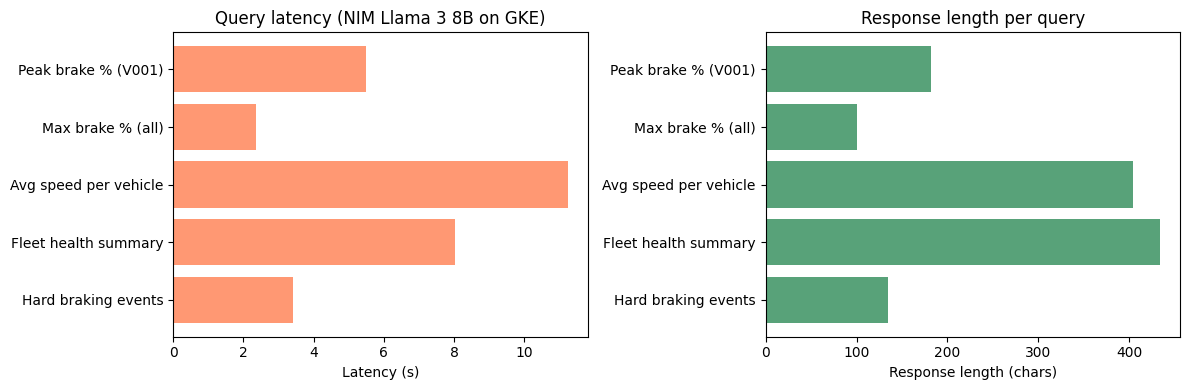

Total: 30.51s | Avg: 6.10s | Model: NIM Llama 3 8B


In [4]:
labels = [r["label"] for r in results_03]
latencies = [r["latency_s"] for r in results_03]
chars = [r["response_chars"] for r in results_03]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].barh(labels, latencies, color="coral", alpha=0.8)
axes[0].set_xlabel("Latency (s)")
axes[0].set_title("Query latency (NIM Llama 3 8B on GKE)")
axes[0].invert_yaxis()

axes[1].barh(labels, chars, color="seagreen", alpha=0.8)
axes[1].set_xlabel("Response length (chars)")
axes[1].set_title("Response length per query")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()
print(f"Total: {sum(latencies):.2f}s | Avg: {sum(latencies)/len(latencies):.2f}s | Model: NIM Llama 3 8B")

## Query 1: Max brake pressure

In [5]:
print("=" * 60)
print("Query 1: Max brake pressure percentage across all vehicles")
print("=" * 60)
answer1 = engine.query(
    "What is the maximum brake_pressure_pct value across all vehicles? Which vehicle had it?",
    sensor_type="can",
)
print(answer1)

Query 1: Max brake pressure percentage across all vehicles
The maximum brake_pressure_pct value across all vehicles is 99.981474%.

This value is observed in vehicle V003 (' 119.993801... ').


## Query 2: Vehicle speed analysis

In [6]:
print("=" * 60)
print("Query 2: Average speed per vehicle")
print("=" * 60)
answer2 = engine.query(
    "What is the average vehicle_speed_kmh for each vehicle? List them from fastest to slowest.",
    sensor_type="can",
)
print(answer2)

Query 2: Average speed per vehicle
Here are the average vehicle speeds for each vehicle, listed from fastest to slowest:

1. V005: 60.913655 km/h
2. V007: 60.827501 km/h
3. V003: 60.891203 km/h
4. V001: 60.127682 km/h
5. V004: 60.421540 km/h
6. V002: 59.941275 km/h
7. V006: 59.370625 km/h
8. V008: 59.252966 km/h
9. V009: 59.160970 km/h

Note that these values are based on the provided data and may not reflect the average vehicle speed for each vehicle over time.


## Query 3: Hard braking events

In [7]:
print("=" * 60)
print("Query 3: Hard braking events (brake_pressure_pct > 90)")
print("=" * 60)
answer3 = engine.query(
    "How many rows have brake_pressure_pct above 90? What is the average vehicle_speed_kmh during these hard braking events?",
    sensor_type="can",
)
print(answer3)

Query 3: Hard braking events (brake_pressure_pct > 90)
There are 400 rows with brake_pressure_pct above 90. The average vehicle_speed_kmh during these hard braking events is 43.75 km/h.


## Query 4: IMU anomaly detection

In [8]:
print("=" * 60)
print("Query 4: IMU anomaly detection")
print("=" * 60)
answer4 = engine.query(
    "Are there any unusual acceleration values in the data? Look at accel_x, accel_y, accel_z "
    "and identify any readings that seem abnormally high or low compared to the typical range.",
    sensor_type="imu",
)
print(answer4)

Query 4: IMU anomaly detection
After analyzing the data, I found that there are a few acceleration values that seem abnormally high or low compared to the typical range. Here are some specific observations:

* In accel_x, there are values as low as -2.13 and as high as 2.16, which are significantly below or above the average value of 0.005.
* In accel_y, there are values as low as -2.00 and as high as 2.50, which are also significantly outside the average range of -0.0069.
* In accel_z, there are values as low as 9.03 and as high as 10.62, which are significantly above or below the average value of 9.8087.

These values may indicate unusual acceleration patterns or events, such as sudden stops, sharp turns, or unexpected movements.


## Query 5: LiDAR point cloud overview

In [9]:
print("=" * 60)
print("Query 5: LiDAR point cloud overview")
print("=" * 60)
answer5 = engine.query(
    "What is the average and max point_count across all LiDAR readings? "
    "What is the typical max_range observed?",
    sensor_type="lidar",
)
print(answer5)

Query 5: LiDAR point cloud overview
Based on the provided data:

* The average point_count across all LiDAR readings is:
  ~254,362
* The max point_count across all LiDAR readings is:
  ~499,991
* The typical max_range observed is:
  ~149.998405


## Query 6: GPS coverage

In [10]:
print("=" * 60)
print("Query 6: GPS coverage area")
print("=" * 60)
answer6 = engine.query(
    "What is the geographic bounding box of the fleet? "
    "Give the min/max latitude and longitude values.",
    sensor_type="gps",
)
print(answer6)

Query 6: GPS coverage area
The geographic bounding box of the fleet is:

Min Latitude: 37.000003°
Max Latitude: 37.999963°
Min Longitude: -122.499824°
Max Longitude: -121.500069°


## Query 7: Fleet-wide summary

In [11]:
print("=" * 60)
print("Query 7: Fleet-wide CAN bus summary")
print("=" * 60)
answer7 = engine.query(
    "Provide a brief fleet health summary: average speed, average throttle, "
    "average brake pressure percentage, and the most common gear position.",
    sensor_type="can",
)
print(answer7)

Query 7: Fleet-wide CAN bus summary
Here is the fleet health summary:

* Average speed: 59.756742 km/h
* Average throttle: 49.732595% (as a percentage of maximum throttle position)
* Average brake pressure: 49.968784% (as a percentage of maximum brake pressure)
* Most common gear position: 3 (average frequency: 2.286791)

Note that the fleet health summary is based on the "Summary statistics" section of the data, which provides pre-computed statistics for the entire fleet of 20,000 vehicles.


## All answers summary

Collected output from all queries above for easy review.

In [12]:
queries = {
    "1. Max brake pressure (CAN)": answer1,
    "2. Avg speed per vehicle (CAN)": answer2,
    "3. Hard braking events (CAN)": answer3,
    "4. IMU anomaly detection": answer4,
    "5. LiDAR point cloud overview": answer5,
    "6. GPS coverage area": answer6,
    "7. Fleet-wide CAN summary": answer7,
}

print("=" * 60)
print("TELEMETRY INSIGHT SUMMARY")
print("=" * 60)
for title, ans in queries.items():
    print(f"\n{'─' * 60}")
    print(f"  {title}")
    print(f"{'─' * 60}")
    print(ans)

print(f"\n{'=' * 60}")
print(f"Pipeline: cuDF + UVM → NIM (Llama 3 8B) on GKE")
print(f"{'=' * 60}")

TELEMETRY INSIGHT SUMMARY

────────────────────────────────────────────────────────────
  1. Max brake pressure (CAN)
────────────────────────────────────────────────────────────
The maximum brake_pressure_pct value across all vehicles is 99.981474%.

This value is observed in vehicle V003 (' 119.993801... ').

────────────────────────────────────────────────────────────
  2. Avg speed per vehicle (CAN)
────────────────────────────────────────────────────────────
Here are the average vehicle speeds for each vehicle, listed from fastest to slowest:

1. V005: 60.913655 km/h
2. V007: 60.827501 km/h
3. V003: 60.891203 km/h
4. V001: 60.127682 km/h
5. V004: 60.421540 km/h
6. V002: 59.941275 km/h
7. V006: 59.370625 km/h
8. V008: 59.252966 km/h
9. V009: 59.160970 km/h

Note that these values are based on the provided data and may not reflect the average vehicle speed for each vehicle over time.

────────────────────────────────────────────────────────────
  3. Hard braking events (CAN)
───────